### Helper functions for data preprocessing

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.stats import boxcox, normaltest
from sklearn.preprocessing import MinMaxScaler
def data_preprocessing(dataframe):
    encoding_cols = dataframe.dtypes[dataframe.dtypes == object]  # Masking
    encoding_cols = encoding_cols.index.tolist()

    labelEnc, oneHotEncoder = LabelEncoder(), OneHotEncoder()
    num_ohc_cols = (dataframe[encoding_cols].apply(lambda x: x.nunique()).sort_values(ascending=False))
    data_encoded = dataframe.__deepcopy__()

    for col in num_ohc_cols.index:
        dat = labelEnc.fit_transform(data_encoded[col]).astype(int)
        data_encoded = data_encoded.drop(col, axis=1)
        new_encoded_data = oneHotEncoder.fit_transform(dat.reshape(-1, 1))

        num_of_cols = new_encoded_data.shape[1]
        col_names = ['_'.join([col, str(x)]) for x in range(num_of_cols)]

        new_df = pd.DataFrame(new_encoded_data.toarray(), index=data_encoded.index, columns=col_names)
        data_encoded = pd.concat([data_encoded, new_df], axis=1)


    print("Encoded Dataframe: ", data_encoded)
    print(data_encoded.columns)
    print(data_encoded.info())
    return data_encoded

def normalizing(dataframe):
    print(normaltest(dataframe.G3.values))
    scaler = MinMaxScaler()
    dataframe.iloc[:, -3:] = scaler.fit_transform(dataframe.iloc[:, -3:])
    dataframe.loc[dataframe.G3 == 0, 'G3'] = 0.01

    log_G3 = np.log(dataframe.G3)
    log_G3 = log_G3.apply(np.abs)
    print(normaltest(log_G3))
    sqrt_G3 = np.sqrt(dataframe.G3)
    print(normaltest(sqrt_G3))
    boxcox_G3 = boxcox(dataframe.G3)
    print(normaltest(boxcox_G3[0]))
    dataframe.iloc[:, -1:] = boxcox_G3[0]

    return dataframe

### Helper functions for visualization

In [19]:
import matplotlib.pyplot as plt

def draw_boxplot_comparision(models,score_array):
    fig = plt.figure()
    fig.suptitle("Boxplot model comparison:")
    ax = fig.add_subplot()
    ax.boxplot(score_array)
    model_names = []
    for model in models:
        model_names.append(model[0])
    ax.set_xticklabels(model_names, rotation=45)
    plt.show()

def draw_linear_comparision(model_name,features,actual_values, predicted_values):
    fig = plt.figure()
    fig.suptitle("R2 model comparison")
    ax = fig.add_subplot()
    ax.set_title(model_name)
    ax.plot(actual_values, predicted_values)
    ax.scatter(features, actual_values)
    plt.show()


### Model comparisons

In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

def model_comparison(model_type, k_splits, data_features, target):
    models_plain_reg = [("LiR", LinearRegression())]
    models_regularized_reg = [("Ridge", Ridge()), ("Las", Lasso())]
    models_other_reg = [("ENet", ElasticNet()), ("KNNR", KNeighborsRegressor()), ("CART", DecisionTreeRegressor()), ("SVR", SVR())]

    kfold = KFold(n_splits=k_splits)
    params = {
        'regularized_regression__alpha': np.geomspace(4, 20, 30)
    }

    result_scores = []
    if model_type == "RE_LE":
        for name, model in models_plain_reg:
            result = cross_val_score(model, data_features, target, cv=kfold, scoring="r2")
            result_scores.append(result)
            print("%s: %.3f (%.3f)" % (name, result.mean(), result.std()))

        draw_boxplot_comparision(models_plain_reg, result_scores)
    elif model_type == "RE_OT":
        for name, model in models_other_reg:
            result = cross_val_score(model, data_features, target, cv=kfold, scoring="r2")
            result_scores.append(result)
            print("%s: %.3f (%.3f)" % (name, result.mean(), result.std()))

        draw_boxplot_comparision(models_other_reg, result_scores)
    elif model_type == "RE_Reg":
        for name, model in models_regularized_reg:
            estimator = Pipeline([("regularized_regression", model)])
            grid = GridSearchCV(estimator, params, cv=kfold)
            grid_fit = grid.fit(data_features, target)
            print(name, "GridCV best score: ", grid.best_score_, "GridCV best params: ", grid.best_params_)
            y_predict = grid.predict(data_features)
            score = r2_score(target, y_predict)
            result_scores.append(score)
            print("r2 score: ", score)


### Main .py file

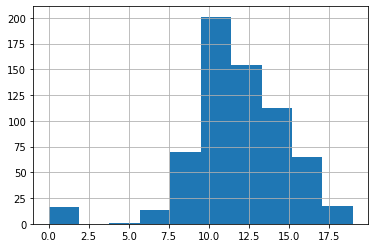

[11 12 14 13 17 15  7 10 16  9  8 18  6  0  1  5 19]
11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
0      15
18     15
7      10
6       3
19      2
5       1
1       1
Name: G3, dtype: int64
  school sex  age address famsize Pstatus  ...  Walc  health absences  G1  G2  G3
0     GP   F   18       U     GT3       A  ...     1       3        4   0  11  11
1     GP   F   17       U     GT3       T  ...     1       3        2   9  11  11
2     GP   F   15       U     LE3       T  ...     3       3        6  12  13  12
3     GP   F   15       U     GT3       T  ...     1       5        0  14  14  14
4     GP   F   16       U     GT3       T  ...     2       5        0  11  13  13

[5 rows x 33 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex      

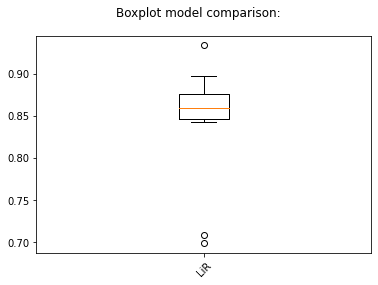

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv("/content/student-por.csv", delimiter=";")

data.G3.hist()
plt.show()

print(data.G3.unique())
print(data.G3.value_counts())

print(data.head())
print(data.info())

data = normalizing(data)

data_encoded = data_preprocessing(data)
feature_cols = [x for x in data_encoded.columns if x != "G3"]
# sns.heatmap(data_encoded[feature_cols])
plt.show()

X_data = data_encoded[feature_cols]
y_data = data_encoded["G3"]

model_comparison("RE_LE", 10, X_data, y_data)


In [22]:
model_comparison("RE_Reg", 10, X_data, y_data)

Ridge GridCV best score:  0.8001067257543264 GridCV best params:  {'regularized_regression__alpha': 4.0}
r2 score:  0.865411928372094
Las GridCV best score:  -0.17770132299852104 GridCV best params:  {'regularized_regression__alpha': 4.0}
r2 score:  0.0


ENet: -0.178 (0.206)
KNNR: -0.019 (0.155)
CART: 0.651 (0.097)
SVR: 0.362 (0.163)


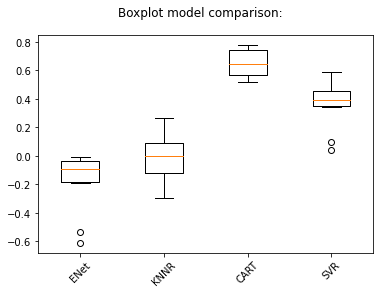

In [23]:
model_comparison("RE_OT", 10, X_data, y_data)